In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [12]:
df = pd.read_csv("UkElectricity_2023.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
df = df.sort_index()
df = df.groupby(df.index).mean()
df = df[['Price']]
df = df.asfreq('H')
df = df.fillna(method='ffill')

In [13]:
# Train-test split
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test = df.iloc[split_index:]
train_values = train['Price'].values
test_values = test['Price'].values

In [14]:
d = 1
diff_series = np.diff(train_values, n=d)
p, q = 1, 1
phi = 0.8
theta = 0.3
mu = np.mean(diff_series)

In [15]:
def arima_predict(train_orig, phi, theta, mu, steps):
    diff_series = np.diff(train_orig)
    predictions = []
    errors = [0]  # e₀ initialized to 0

    last_value = train_orig[-1]

    for t in range(steps):
        ar_part = phi * (diff_series[-1] if len(diff_series) > 0 else 0)
        ma_part = theta * errors[-1]
        forecast_diff = mu + ar_part + ma_part

        forecast_value = last_value + forecast_diff  # invert differencing
        predictions.append(forecast_value)

        # Simulate actual (for error) with test value or fake it (in real case you'd use residuals)
        if t < len(test_values):
            actual_diff = test_values[t] - last_value
        else:
            actual_diff = 0

        error = actual_diff - forecast_diff
        errors.append(error)
        diff_series = np.append(diff_series, forecast_diff)
        last_value = forecast_value

    return predictions

forecast = arima_predict(train_values, phi, theta, mu, len(test_values))
forecast = pd.Series(forecast, index=test.index)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

results = pd.concat([test['Price'], forecast], axis=1)
results.columns = ['Actual', 'Forecast']

mse = mean_squared_error(results['Actual'], results['Forecast'])
mae = mean_absolute_error(results['Actual'], results['Forecast'])
rmse = np.sqrt(mse)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE:  11.31
MSE:  235.07
RMSE: 15.33


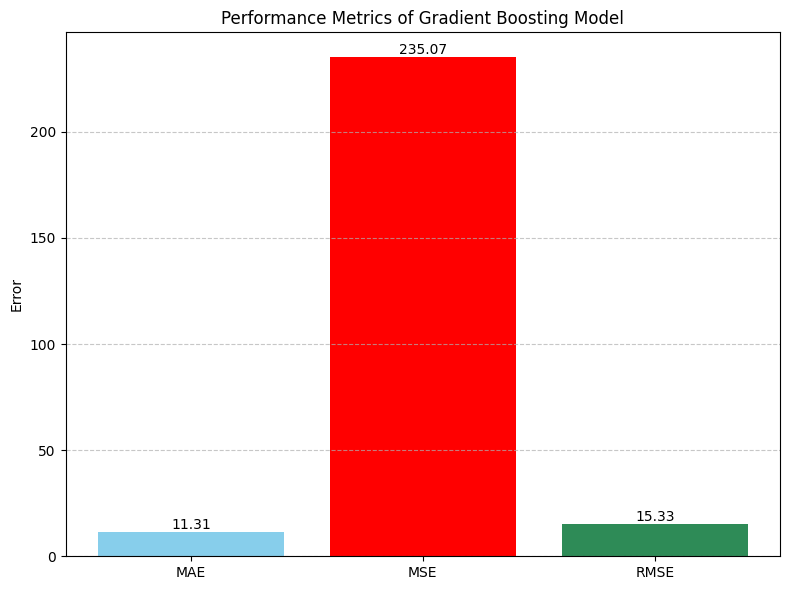

In [18]:
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, rmse]

# Plot bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['skyblue', 'red', 'seagreen'])
plt.title('Performance Metrics of Gradient Boosting Model')
plt.ylabel('Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
